# 데이터셋 준비

In [ ]:
!unzip -q /content/drive/My\ Drive/Datasets/RocoPicker_dataset.zip -d dataset

# 텐서플로우 2.0설치;

In [ ]:
!pip install tensorflow==2.1.0 -q

     |████████▉                       | 116.3MB 1.4MB/s eta 0:03:34
ERROR: Operation cancelled by user


In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.4.1'

# 필요한 모듈 임포트

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
keras = tf.keras

# 이미지 제너레이터 생성

In [ ]:
import pathlib
train_dir = pathlib.Path('dataset/RocoPicker_dataset/train')
num_of_train_images = len(list(train_dir.glob("*/*.png"))) + len(list(train_dir.glob("*/*.jpg")))
num_of_train_images

4551

In [ ]:
len(list(train_dir.glob("Not_Roco/*.png"))) + len(list(train_dir.glob("Not_Roco/*.jpg")))

1976

In [ ]:
len(list(train_dir.glob("Roco/*.png")))+ len(list(train_dir.glob("Roco/*.jpg")))

2575

In [ ]:
test_dir = pathlib.Path('dataset/RocoPicker_dataset/validation')
len(list(test_dir.glob("Not_Roco/*.png"))) + len(list(test_dir.glob("Not_Roco/*.jpg")))

200

In [ ]:
len(list(test_dir.glob("Roco/*.png"))) + len(list(test_dir.glob("Roco/*.jpg")))

200

In [ ]:
imageGenerator = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True, 
    rescale=1.0/255.0,
    rotation_range=90, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.3,
    brightness_range=[0.5,1.3] )


# 하이퍼파라미터

In [ ]:
IMAGE_HEIGHT = 299 #https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568
IMAGE_WIDTH = 299
BATCH_SIZE = 20

# 이미지 배치 데이터 생성

In [ ]:
generated_train_data = imageGenerator.flow_from_directory(train_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), color_mode='rgb', classes=['Roco', 'Not_Roco'], batch_size = BATCH_SIZE, shuffle=True)

Found 4551 images belonging to 2 classes.


In [ ]:
val_dir = pathlib.Path('dataset/RocoPicker_dataset/validation')
generated_validation_data = imageGenerator.flow_from_directory(val_dir,  target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), color_mode='rgb', classes=['Roco', 'Not_Roco'], batch_size = BATCH_SIZE, shuffle=True)

Found 400 images belonging to 2 classes.


# 배치 데이터 확인

In [ ]:
CLASS_NAMES = np.array(['Roco','Not_Roco'])

In [ ]:
CLASS_NAMES

array(['Roco', 'Not_Roco'], dtype='<U8')

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10)) # 이미지 크기를 10, 10 으로 조정
  for n in range(20):
    ax = plt.subplot(4, 5, n+1) # 5행 5열로 잡은 것 중 n+1번째에 그림을 그림.
    plt.imshow(image_batch[n])  # 이미지 표시
    plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
    plt.axis('off')
# ------------------------------------------------------------------

import matplotlib.pyplot as plt

image_batch, label_batch = next(generated_train_data)
# show_batch(image_batch, label_batch)

In [ ]:
print(label_batch[6])

[1. 0.]


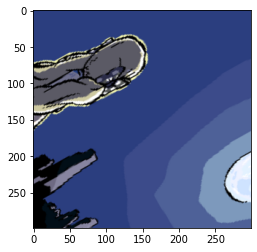

In [ ]:
plt.imshow(image_batch[6])

# 모델 생성
https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko

In [ ]:
IMG_SHAPE = (IMAGE_HEIGHT,IMAGE_WIDTH,3)

base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top = False)

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 150, 150, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
base_model.trainable = False

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [ ]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(2, activation="softmax")

In [ ]:
model = tf.keras.Sequential([
                             base_model,
                             global_average_layer,
                             prediction_layer
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# 모델 로드

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/trained_model/rocopicker_Season_2')

# 모델 학습

In [ ]:
MODEL_DIR = "/content/drive/My\ Drive/trained_model/rocopicker2_RMS"

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/My Drive/trained_model/rocopicker_Season_2',
        monitor='val_loss',
        save_best_only=True,
        verbose=1)
]

model.fit(generated_train_data, callbacks=callbacks, epochs=30, validation_data=generated_validation_data, class_weight={0 : 2575/4551 , 1: 1- 2575/4551})

Epoch 1/30
228/228 [==============================] - 422s 2s/step - loss: 0.3188 - accuracy: 0.6299 - val_loss: 0.5620 - val_accuracy: 0.7250

Epoch 00001: val_loss improved from inf to 0.56201, saving model to /content/drive/My Drive/trained_model/rocopicker_Season_2
INFO:tensorflow:Assets written to: /content/drive/My Drive/trained_model/rocopicker_Season_2/assets
Epoch 2/30
228/228 [==============================] - 401s 2s/step - loss: 0.2587 - accuracy: 0.7306 - val_loss: 0.5786 - val_accuracy: 0.7050

Epoch 00002: val_loss did not improve from 0.56201
Epoch 3/30
228/228 [==============================] - 374s 2s/step - loss: 0.2366 - accuracy: 0.7593 - val_loss: 0.5031 - val_accuracy: 0.7525

Epoch 00003: val_loss improved from 0.56201 to 0.50307, saving model to /content/drive/My Drive/trained_model/rocopicker_Season_2
INFO:tensorflow:Assets written to: /content/drive/My Drive/trained_model/rocopicker_Season_2/assets
Epoch 4/30
228/228 [==============================] - 369s 2s

In [ ]:
model.save('/content/drive/My Drive/trained_model/rocopicker2_RMS2')

# 사진을 이용한 평가

In [ ]:
import cv2

im = cv2.imread("/content/check08.jpg").astype(np.float32) # 이미지 로드
im = im * (1.0/255.0) # 이미지 정규화
resized_img = cv2.resize(im, (299,299)) # 이미지 크기를 맞게 변형
rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
expdim_img = np.expand_dims(rgb_img, axis=0) # 배치는 1개

In [ ]:
predict = model.predict(expdim_img)
predict

array([[0.88898176, 0.11101828]], dtype=float32)

로코: 88.9%, Not_로코: 11.1%


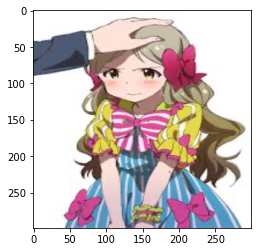

In [ ]:
plt.imshow(rgb_img)
print("로코: {:0.3}%, Not_로코: {:0.3}%".format(predict[0][0]*100, predict[0][1]*100))

# Model evaluate (for debugging)

In [ ]:
model.evaluate(generated_validation_data)

20/20 [==============================] - 225s 11s/step - loss: 0.5259 - accuracy: 0.7375


[0.5258844941854477, 0.7375]

In [ ]:
model.inputs

[<tf.Tensor 'input_1:0' shape=(None, 299, 299, 3) dtype=float32>]

# 텐서플로우 JS

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 6.9MB/s 
     |████████████████████████████████| 112kB 19.5MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [ ]:
!tensorflowjs_converter --input_format keras \
                       /content/drive/My\ Drive/trained_model/rocopicker_Season_2 \
                       /content/drive/My\ Drive/trained_model/rocopicker_Season_2js

2021-02-28 11:00:53.652120: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
usage: TensorFlow.js model converters. [-h]
                                       [--input_format {keras,tf_frozen_model,tf_saved_model,tf_hub,tfjs_layers_model,keras_saved_model}]
                                       [--output_format {keras,tfjs_layers_model,keras_saved_model,tfjs_graph_model}]
                                       [--signature_name SIGNATURE_NAME]
                                       [--saved_model_tags SAVED_MODEL_TAGS]
                                       [--quantize_float16 [QUANTIZE_FLOAT16]]
                                       [--quantize_uint8 [QUANTIZE_UINT8]]
                                       [--quantize_uint16 [QUANTIZE_UINT16]]
                                       [--quantization_bytes {1,2}]
                                       [--split_weights_by_layer] [--version]
                           

In [ ]:
import tensorflow as tf
import tensorflowjs as tfjs

model = tf.keras.models.load_model('/content/drive/My Drive/trained_model/rocopicker_Season_2')

tfjs.converters.save_keras_model(model, '/content/drive/My Drive/trained_model/rocopickerjs')

/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [ ]:
tensorflowjs_converter --input_format tfjs_layers_model --output_format tfjs_graph_model /content/drive/My\ Drive/trained_model/rocopickerjs/model.json graph_model

SyntaxError: ignored

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/trained_model/rocopicker2')

In [ ]:
model.save_weights('/content/drive/My Drive/trained_model/rocopicker3')

In [ ]:
tf.saved_model.save(model,'/content/drive/My Drive/trained_model/rocopickerjs')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/trained_model/rocopickerjs/assets


In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model input_path=/content/model output_path=/content/outputmodel

Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/converter.py", line 645, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/converter.py", line 649, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/converter.py", line 595, in convert
    strip_debug_ops=args.strip_debug_ops)
  File "/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/tf_saved_model_conversion_v2.py", line 416, in convert_tf_saved_model
    model = load(saved_model_dir, saved_model_tags)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/saved_model/load.py", line 528, in load
    return load_internal(export_dir, tags)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/saved_model/load.py", line 5

In [ ]:
!cp -r /content/drive/My\ Drive/trained_model/rocopicker2 /content/model